In [16]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

In [17]:
config = {
        # Arquitectura
        "lstm_units_1": 64,
        "lstm_units_2": 32,
        "dense_units": 16,
        "dropout_rate": 0.3,

        # Entrenamiento
        "epochs": 150,
        "batch_size": 250,
        "early_stopping_patience": 20,
        "learning_rate": None,  # Si querés usar Adam con tasa específica

        # Regularización
        "l2_lambda": 0.001,

        # Optimizador
        "optimizer": "rmsprop",  # adam, sgd, rmsprop, etc.

        # Preprocesamiento
        "scaler_name": "robust",  # standard o robust

        # Ventana temporal
        "window_size": 3,
        "feature_cols" : ['tn', 'tn_lag1', 
                          #'tn_lag6', 
                          #'tn_lag12', 
                          'tn_diff1', 
                          #'tn_diff6',
                'rolling_mean3', 'rolling_std3', 'rolling_max3', 'rolling_min3','rolling_max6','rolling_min6',"size"],
    }


In [18]:
# Cargar de nuevo por claridad
df = pd.read_csv("../../data/raw/sell-in.csv", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Agregación mensual por producto
df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()

# Crear características por producto
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    
    # Crear features con groupby + transform
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    #df["tn_lag6"] = df.groupby("product_id")["tn"].shift(6)
    #df["tn_lag12"] = df.groupby("product_id")["tn"].shift(12)

    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    #df["tn_diff6"] = df["tn"] - df["tn_lag6"]
    df["size"] = df.groupby("product_id")["tn"].transform("size")
    

    df["rolling_mean3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    df["rolling_std3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    
    df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)
del df
gc.collect()
print(df_features.shape)

(31243, 12)


In [19]:
# Último período disponible
ultimo_mes = df_features["periodo"].max()

# Definir los 3 meses anteriores
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')

# Filtrar productos con datos en al menos 3 de esos meses
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]

# Contar cuántos meses tiene cada producto
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()

# Seleccionar productos válidos
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index

# Filtrar el dataframe original
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()
print(df_features.shape)

(25804, 12)


In [20]:
# df_test = df_features[df_features["periodo"] == pd.to_datetime(201912, format="%Y%m")].copy()
# df_features[df_features["periodo"].isin(pd.to_datetime([201911, 201912], format="%Y%m")) ]
df_test = df_features[df_features["periodo"] == pd.to_datetime(201910, format="%Y%m")].copy()
df_features[df_features["periodo"].isin(pd.to_datetime([201910, 201911, 201912], format="%Y%m")) ]

,product_id,periodo,tn,tn_lag1,tn_diff1,size,rolling_mean3,rolling_std3,rolling_max3,rolling_min3,rolling_max6,rolling_min6
33,20001,2019-10-01,1561.50552,1660.00561,-98.50009,36,1533.448027,235.839048,1678.99318,1261.34529,1678.99318,1109.93769
34,20001,2019-11-01,1397.37231,1561.50552,-164.13321,36,1494.285473,207.656962,1660.00561,1261.34529,1678.99318,1109.93769
35,20001,2019-12-01,1504.68856,1397.37231,107.31625,36,1539.627813,132.676441,1660.00561,1397.37231,1678.99318,1109.93769
69,20002,2019-10-01,1979.53635,1090.18771,889.34864,36,990.139950,153.190813,1090.18771,813.78215,1287.62346,813.78215
70,20002,2019-11-01,1423.57739,1979.53635,-555.95896,36,1294.502070,609.142005,1979.53635,813.78215,1979.53635,813.78215
...,...,...,...,...,...,...,...,...,...,...,...,...
31189,21271,2019-11-01,0.01301,0.02453,-0.01152,27,0.023900,0.005771,0.02933,0.01784,0.04347,0.00445
31190,21271,2019-12-01,0.00298,0.01301,-0.01003,27,0.022290,0.008387,0.02933,0.01301,0.02933,0.00445
31208,21276,2019-10-01,0.02079,0.01856,0.00223,10,0.011147,0.008268,0.01856,0.00223,0.10173,0.00223
31209,21276,2019-11-01,0.03341,0.02079,0.01262,10,0.017333,0.004206,0.02079,0.01265,0.09283,0.00223


In [21]:
# ================================
# 2. SCALING Y VENTANAS TEMPORALES
# ================================

window_size = config["window_size"]
scaler_name = config["scaler_name"]

feature_cols = config["feature_cols"]

# Agrupar por producto
productos = df_features["product_id"].unique()
scalers = {}  # Guardamos los scalers por producto

X, y, productos_list = [], [], []

for producto in productos:
    df_prod = df_features[df_features["product_id"] == producto].copy()

    if len(df_prod) < window_size + 2:
        continue  # No tiene suficientes datos

    # Escalado por producto
    
    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_features = scaler.fit_transform(df_prod[feature_cols])
    scalers[producto] = scaler

    for i in range(window_size, len(df_prod) - 2):
        X.append(scaled_features[i - window_size:i])  # (window_size, n_features)
        y.append(scaled_features[i + 2][0])  # Target: tn escalado en t+2
        productos_list.append(producto)

X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [22]:

# ================================
# 3. TRAIN / TEST SPLIT
# ================================
from sklearn.model_selection import train_test_split

# productos_train, productos_test = train_test_split(np.unique(productos_list), test_size=0.2, random_state=42)

# train_mask = [p in productos_train for p in productos_list]
# test_mask = [p in productos_test for p in productos_list]

# X_train, X_test = X[train_mask], X[test_mask]
# y_train, y_test = y[train_mask], y[test_mask]

# Primero reconstruimos la lista de periodos asociados a cada muestra
periodos = []

for producto in productos:
    df_prod = df_features[df_features["product_id"] == producto].copy()

    if len(df_prod) < window_size + 2:
        continue

    for i in range(window_size, len(df_prod) - 2):
        # El periodo objetivo (de y) es en t+2, entonces corresponde a:
        periodo_target = df_prod.iloc[i + 2]["periodo"]
        periodos.append(periodo_target)

# Convertimos a numpy para facilitar indexado
periodos = np.array(periodos)

# Definimos el umbral de corte (por ejemplo, predecimos diciembre 2019)
fecha_corte = pd.to_datetime("2019-12-01")

# Creamos máscaras según el periodo de y
train_mask = periodos < fecha_corte
test_mask = periodos == fecha_corte  # opcional: podrías usar > fecha_corte para más test

# Aplicamos la máscara
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
productos_test = np.array(productos_list)[test_mask]

In [31]:

# ================================
# 4. MODELO LSTM
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
from tensorflow.keras.optimizers import Adam, RMSprop



# Configuración y semillas
semillas = [42, 101, 202, 303, 404]  # Tus semillas
l2_lambda = config["l2_lambda"]
optimizer_name = config["optimizer"]
epochs = config["epochs"]
batch_size = config["batch_size"]
early_stopping_patience = config["early_stopping_patience"]

# Función para crear modelo (con semilla como parámetro)
def crear_modelo(semilla, window_size, n_features):
    tf.keras.utils.set_random_seed(semilla)  # Fija semilla para TensorFlow
    
    model = Sequential([
        LSTM(200, activation='tanh', return_sequences=True, 
             input_shape=(window_size, n_features),
             kernel_regularizer=l2(l2_lambda) if l2_lambda > 0 else None),
        Dropout(0.2, seed=semilla),
        LSTM(32, activation='tanh'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    # Configurar optimizer con semilla
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=0.001)
    else:
        optimizer = optimizer_name
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Entrenamiento con semillerio
def entrenar_con_semillerio(X_train, y_train, X_test, y_test):
    modelos = []
    historiales = []
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    
    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=15)
    ]
    
    for i, semilla in enumerate(semillas):
        print(f"\nEntrenando modelo con semilla {semilla} ({i+1}/{len(semillas)})")
        
        model = crear_modelo(semilla, window_size, n_features)
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        modelos.append(model)
        historiales.append(history)
    
    return modelos, historiales



modelos, historiales = entrenar_con_semillerio(X_train, y_train, X_test, y_test)



Entrenando modelo con semilla 42 (1/5)
Epoch 1/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.6050 - mae: 0.5690 - val_loss: 0.7716 - val_mae: 0.7087 - learning_rate: 0.0010
Epoch 2/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5820 - mae: 0.5585 - val_loss: 0.7465 - val_mae: 0.6950 - learning_rate: 0.0010
Epoch 3/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5726 - mae: 0.5543 - val_loss: 0.7376 - val_mae: 0.6901 - learning_rate: 0.0010
Epoch 4/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5693 - mae: 0.5536 - val_loss: 0.7291 - val_mae: 0.6850 - learning_rate: 0.0010
Epoch 5/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5666 - mae: 0.5524 - val_loss: 0.7257 - val_mae: 0.6829 - learning_rate: 0.0010
Epoch 6/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5638 - mae: 0.5514 - val_loss: 0.7259 - val_mae: 0.6829 - learning_rate: 0.0010
Epoch 7/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5622 - mae: 0.5504 - val_loss: 0.7261 - val_ma

In [ ]:
# # ================================
# # 5. PREDICCIÓN t+2
# # ================================

# def predecir_t2(product_id, df_features_full):
#     """
#     product_id: ID del producto a predecir.
#     df_features_full: dataframe con las features ya procesadas.
#     """
#     df_prod = df_features_full[df_features_full["product_id"] == product_id].copy()
#     scaler = scalers[product_id]

#     ultimos = df_prod[feature_cols].iloc[-window_size:]
#     ultimos_scaled = scaler.transform(ultimos)

#     X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
#     y_pred_scaled = model.predict(X_new)

#     # Inversión del escalado solo sobre la primera columna (tn)
#     tn_mean = scaler.center_[0]
#     tn_std = scaler.scale_[0]

#     y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
#     return y_pred

In [ ]:
# # ================================
# # 5. PREDICCIÓN t+2
# # ================================

def predecir_todos_t2_semillerio(df_features_full, modelos, scalers, feature_cols, window_size):
    """
    Predice tn en t+2 para todos los productos usando un ensemble de modelos con semillerio.

    Args:
        df_features_full (pd.DataFrame): dataframe completo con features
        modelos (list): lista de modelos LSTM entrenados con diferentes semillas
        scalers (dict): diccionario con los StandardScaler por producto
        feature_cols (list): lista de columnas de features
        window_size (int): tamaño de la ventana temporal

    Returns:
        pd.DataFrame: dataframe con columnas ["product_id", "tn_t2_pred"]
    """
    productos = df_features_full["product_id"].unique()
    resultados = []

    for pid in productos:
        df_prod = df_features_full[df_features_full["product_id"] == pid]
        
        if len(df_prod) < window_size:
            continue  # no hay suficientes datos

        try:
            # Preparar datos
            ultimos = df_prod[feature_cols].iloc[-window_size:]
            scaler = scalers[pid]
            ultimos_scaled = scaler.transform(ultimos)
            X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
            
            # Predecir con todos los modelos y promediar
            predicciones = []
            for model in modelos:
                y_pred_scaled = model.predict(X_new, verbose=0)
                tn_mean = scaler.center_[0]
                tn_std = scaler.scale_[0]
                y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
                predicciones.append(y_pred)
            
            y_pred_final = np.mean(predicciones)
            
            # Opcional: eliminar outliers extremos antes de promediar
            # y_pred_final = np.mean(np.clip(predicciones, 
            #                           np.percentile(predicciones, 10),
            #                           np.percentile(predicciones, 90)))

        except Exception as e:
            print(f"Error al predecir producto {pid}: {e}")
            y_pred_final = np.mean(df_prod["tn"])  # Valor por defecto si falla
            
        # Asegurar predicción positiva
        y_pred_final = max(0, y_pred_final)
        resultados.append({"product_id": pid, "tn_t2_pred": y_pred_final})

    return pd.DataFrame(resultados)

In [34]:
df_preds_t2 = predecir_todos_t2_semillerio(
    df_features,
    modelos,
    scalers,
    feature_cols,
    window_size
)

print(df_preds_t2.head())

Error al predecir producto 20127: np.int64(20127)
Error al predecir producto 20210: np.int64(20210)
Error al predecir producto 20686: np.int64(20686)
Error al predecir producto 20703: np.int64(20703)
Error al predecir producto 20962: np.int64(20962)
Error al predecir producto 20975: np.int64(20975)
Error al predecir producto 20995: np.int64(20995)
Error al predecir producto 21087: np.int64(21087)
Error al predecir producto 21214: np.int64(21214)
   product_id   tn_t2_pred
0       20001  1358.207532
1       20002  1064.055289
2       20003   799.204270
3       20004   598.498170
4       20005   566.988761


In [ ]:
# df_preds_t2 = predecir_todos_t2(
#     df_features_full=df_features,
#     model=model,
#     scalers=scalers,
#     feature_cols=feature_cols,
#     window_size=window_size
# )

# print(df_preds_t2.head())

Error al predecir producto 20127: np.int64(20127)
Error al predecir producto 20210: np.int64(20210)
Error al predecir producto 20686: np.int64(20686)
Error al predecir producto 20703: np.int64(20703)
Error al predecir producto 20962: np.int64(20962)
Error al predecir producto 20975: np.int64(20975)
Error al predecir producto 20995: np.int64(20995)
Error al predecir producto 21087: np.int64(21087)
Error al predecir producto 21214: np.int64(21214)
   product_id   tn_t2_pred
0       20001  1386.858321
1       20002  1049.577596
2       20003   805.068777
3       20004   594.459138
4       20005   567.989714


In [35]:
df_preds_t2

,product_id,tn_t2_pred
0,20001,1358.207532
1,20002,1064.055289
2,20003,799.204270
3,20004,598.498170
4,20005,566.988761
...,...,...
893,21265,0.057741
894,21266,0.058973
895,21267,0.062752
896,21271,0.019029


In [36]:
df_final = df_test.merge(df_preds_t2, on="product_id", how="left")
df_final

,product_id,periodo,tn,tn_lag1,tn_diff1,size,rolling_mean3,rolling_std3,rolling_max3,rolling_min3,rolling_max6,rolling_min6,tn_t2_pred
0,20001,2019-10-01,1561.50552,1660.00561,-98.50009,36,1533.448027,235.839048,1678.99318,1261.34529,1678.99318,1109.93769,1358.207532
1,20002,2019-10-01,1979.53635,1090.18771,889.34864,36,990.139950,153.190813,1090.18771,813.78215,1287.62346,813.78215,1064.055289
2,20003,2019-10-01,1081.36645,967.77116,113.59529,36,772.856643,173.430362,967.77116,635.59563,967.77116,565.33774,799.204270
3,20004,2019-10-01,1064.69633,786.17140,278.52493,36,596.673437,165.299068,786.17140,482.13372,786.17140,466.70901,598.498170
4,20005,2019-10-01,996.78275,879.52808,117.25467,36,720.648620,172.802806,879.52808,536.66800,897.26297,536.66800,566.988761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,21265,2019-10-01,0.10921,0.01707,0.09214,10,0.020863,0.007579,0.02959,0.01593,0.36405,0.01593,0.057741
894,21266,2019-10-01,0.11831,0.02844,0.08987,10,0.034133,0.022721,0.05916,0.01480,0.36178,0.01480,0.058973
895,21267,2019-10-01,0.09676,0.01830,0.07846,10,0.044453,0.028314,0.07452,0.01830,0.24451,0.01830,0.062752
896,21271,2019-10-01,0.02453,0.02933,-0.00480,27,0.019933,0.008545,0.02933,0.01263,0.04347,0.00185,0.019029


In [37]:
numerador = (df_final["tn"]- df_final["tn_t2_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

np.float64(0.2617732191017372)

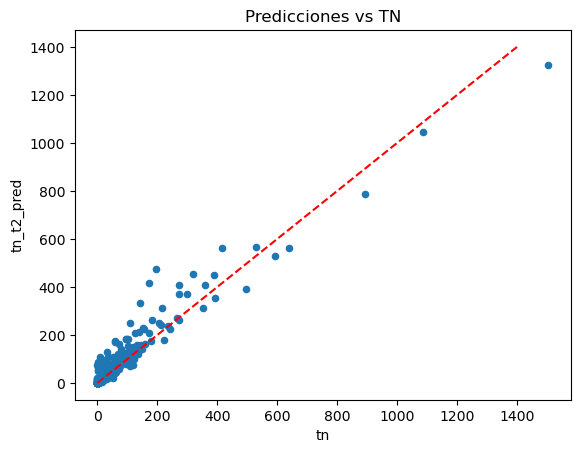

In [168]:
import matplotlib.pyplot as plt
df_final.plot(kind="scatter", x="tn", y="tn_t2_pred", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [176]:
import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de dispersión con el product_id en el hover
fig.add_trace(go.Scatter(
    x=df_final["tn"],
    y=df_final["tn_t2_pred"],
    mode='markers',
    name='Datos',
    customdata=df_final["product_id"],  # Pasamos el product_id como dato adicional
    hovertemplate=(
        "<b>TN Real</b>: %{x}<br>"
        "<b>TN Predicho</b>: %{y}<br>"
        "<b>Product ID</b>: %{customdata}<br>"
        "<extra></extra>"  # Elimina información adicional automática
    ),
    marker=dict(size=8, opacity=0.7)  # Opcional: ajustar tamaño y transparencia
))

# Añadir la línea de referencia y=x
fig.add_trace(go.Scatter(
    x=[0, 1400],
    y=[0, 1400],
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

# Configurar el diseño del gráfico para que sea cuadrado
fig.update_layout(
    title='Predicciones vs TN',
    xaxis_title='TN Real',
    yaxis_title='TN Predicho',
    showlegend=True,
    # Forzar misma escala en ejes X e Y
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    # Tamaño cuadrado (opcional)
    width=600,
    height=600,
    # Rango fijo para ambos ejes (opcional)
    xaxis_range=[0, 50],
    yaxis_range=[0, 50]
)

# Mostrar el gráfico
fig.show()

In [170]:
print(df_final["tn_t2_pred"].sum(),"|",df_final["tn"].sum())

32015.00363455506 | 25987.52668


In [171]:
df_final["error"] = (df_final["tn"] - df_final["tn_t2_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)
df_final[["product_id" ,"tn", "tn_t2_pred", "error", "error_relativo"]].head(20)


,product_id,tn,tn_t2_pred,error,error_relativo
7,20008,195.36854,476.125315,280.756775,1.437062
11,20012,173.13004,416.963649,243.833609,1.408384
17,20018,141.63570,331.111573,189.475873,1.337769
0,20001,1504.68856,1322.727699,181.960861,0.120929
5,20006,417.23228,561.699207,144.466927,0.346251
27,20028,109.92618,247.659092,137.732912,1.252958
13,20014,272.02812,408.512577,136.484457,0.501729
12,20013,318.09141,453.887662,135.796252,0.426910
44,20048,58.89241,175.996790,117.104380,1.988446
40,20044,59.61747,169.484635,109.867165,1.842869


In [172]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_11172\804960764.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



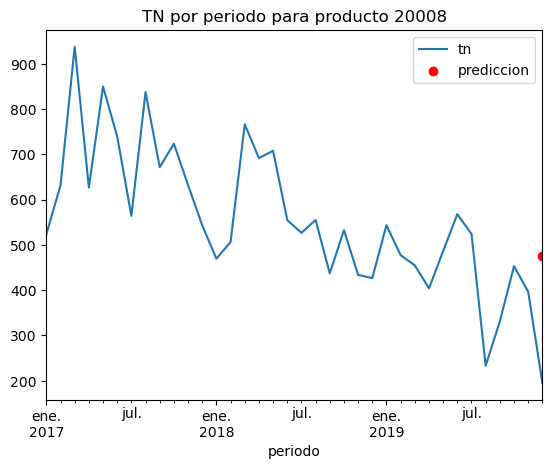

In [173]:

prod = 20008
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["tn_t2_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()